In [13]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 15

# Specify each path

In [14]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [15]:
NUM_CLASSES = 5

# Dataset reading

In [16]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [17]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [22]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_4 (Dropout)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │         2,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30)             │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,725 (18.46 KB)

 Trainable params: 4,565 (17.83 KB)

 Non-trainable params: 160 (640.00 B)

In [23]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust as necessary
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Model training

In [25]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2656 - loss: 1.7350
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3331 - loss: 1.5789 - val_accuracy: 0.6035 - val_loss: 1.3832
Epoch 2/1000
 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5469 - loss: 1.1836
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5920 - loss: 1.1377 - val_accuracy: 0.7594 - val_loss: 1.1311
Epoch 3/1000
 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7109 - loss: 0.9034
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7008 - loss: 0.8868 - val_accuracy: 0.9576 - val_loss: 0.8485
Epoch 4/1000
 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.7612
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.keras


In [26]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 1.0000 - loss: 0.0026


In [27]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [28]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
[5.3573652e-09 1.6870678e-07 1.0155094e-03 9.9898440e-01 1.6374957e-08]
3


# Confusion matrix

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step


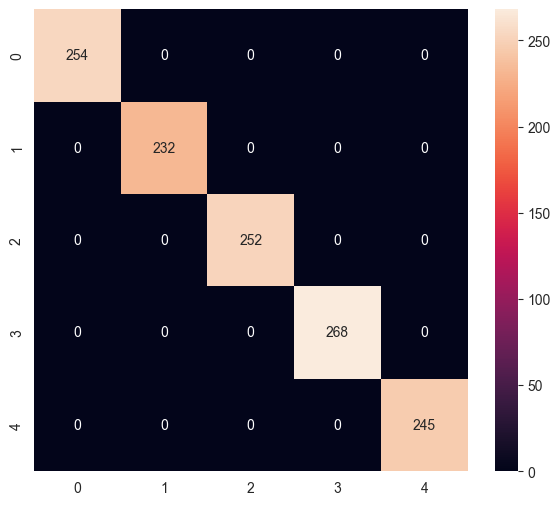

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       254
           1       1.00      1.00      1.00       232
           2       1.00      1.00      1.00       252
           3       1.00      1.00      1.00       268
           4       1.00      1.00      1.00       245

    accuracy                           1.00      1251
   macro avg       1.00      1.00      1.00      1251
weighted avg       1.00      1.00      1.00      1251



In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [30]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [31]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/wd/3tl0gn3s3tb6d983xwht1bh40000gn/T/tmprre6bqc8/assets


INFO:tensorflow:Assets written to: /var/folders/wd/3tl0gn3s3tb6d983xwht1bh40000gn/T/tmprre6bqc8/assets


Saved artifact at '/var/folders/wd/3tl0gn3s3tb6d983xwht1bh40000gn/T/tmprre6bqc8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  11162182576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11155418448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11155346704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11155465488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11155415632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11155348112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11144855216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11151038064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11142493104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11142494160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11142458704: Tenso

W0000 00:00:1737354273.023119  751993 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1737354273.023475  751993 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.


10552

# Inference test

In [32]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [33]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [34]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [35]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 120 µs, sys: 184 µs, total: 304 µs
Wall time: 235 µs


In [36]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.0214872e-09 1.6134427e-07 9.8433276e-04 9.9901557e-01 1.6828547e-08]
3
